## California Housing Price
- predict median price per district
- model: regression/labeled supervised learning
- dataset: https://github.com/ageron/handson-ml2/tree/master/datasets/housing

### 1. Read Data

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import tensorflow as tf
from tensorflow import feature_column
from tensorflow.keras import layers

In [28]:
df=pd.read_csv("california_housing.csv")
df['median_house_value']/=1000
df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452.6,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358.5,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352.1,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341.3,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342.2,NEAR BAY


In [29]:
df.shape

(20640, 10)

In [30]:
df.isna().sum()
#total_badrooms 207/20640 is missing

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        207
population              0
households              0
median_income           0
median_house_value      0
ocean_proximity         0
dtype: int64

In [31]:
df=df.dropna()
df.isna().sum()

longitude             0
latitude              0
housing_median_age    0
total_rooms           0
total_bedrooms        0
population            0
households            0
median_income         0
median_house_value    0
ocean_proximity       0
dtype: int64

### 2. Data Exploration

In [32]:
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000,20433.000000
mean,-119.570689,35.633221,28.633094,2636.504233,537.870553,1424.946949,499.433465,3.871162,206.864413
std,2.003578,2.136348,12.591805,2185.269567,421.385070,1133.208490,382.299226,1.899291,115.435667
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14.999000
25%,-121.800000,33.930000,18.000000,1450.000000,296.000000,787.000000,280.000000,2.563700,119.500000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.536500,179.700000
75%,-118.010000,37.720000,37.000000,3143.000000,647.000000,1722.000000,604.000000,4.744000,264.700000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500.001000


#### Take away:
- comparing to 75%, max for `total_rooms`, `population`, `households` need a further check.
- abnormal data for target col `median_house_value`.

In [33]:
df=df[(df.total_rooms<=5000)&(df.total_bedrooms<=1000)&(df.population<=2500)&(df.households<=1000)&
      (df.median_income<=8)&(df.median_house_value<500)]

#df.median_house_value.hist(bins=100)
#df.total_bedrooms.hist(bins=100)
#df.median_income.hist(bins=100)
#df.total_rooms.hist(bins=100)
#df.population.hist(bins=100)
#df.households.hist(bins=100)

In [34]:
from sklearn.preprocessing import StandardScaler

scaler=StandardScaler()
scaled_df=scaler.fit_transform(df.loc[:,df.columns!='ocean_proximity']) 
scaled_df=pd.DataFrame(scaled_df,columns=df.columns.values[0:-1])
scaled_df.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
0,-1.304883,0.979618,1.812895,-0.581462,-1.176249,-1.202281,-1.189649,2.533741,1.723464
1,-1.309868,0.979618,1.812895,-0.778082,-0.946837,-1.083693,-0.959439,1.420463,1.610331
2,-1.309868,0.979618,1.812895,-0.418462,-0.717426,-1.070304,-0.740191,0.181256,1.619758
3,-1.309868,0.979618,1.812895,-1.139739,-1.058994,-1.361037,-1.101950,0.312701,0.860301
4,-1.309868,0.975021,1.812895,0.506566,0.348063,-0.058477,0.657516,0.052225,1.169321


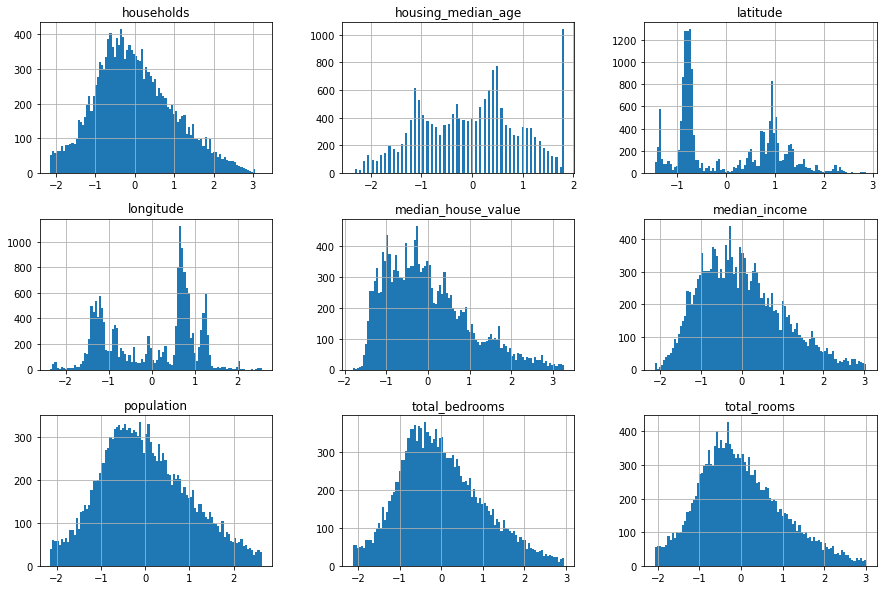

In [35]:
scaled_df.hist(bins=100,figsize=(15,10))
plt.show()

### 3. Feature Engineering

In [36]:
feature_columns = []

In [59]:
#location
resolution_in_degrees = 0.4 

latitude_num = tf.feature_column.numeric_column("latitude")
latitude_bins = list(np.arange(int(min(scaled_df['latitude'])), int(max(scaled_df['latitude'])), resolution_in_degrees))
latitude = tf.feature_column.bucketized_column(latitude_num, latitude_bins)

longitude_num = tf.feature_column.numeric_column("longitude")
longitude_bins = list(np.arange(int(min(scaled_df['longitude'])), int(max(scaled_df['longitude'])), resolution_in_degrees))
longitude = tf.feature_column.bucketized_column(longitude_num, longitude_bins)

lat_x_lon = tf.feature_column.crossed_column([latitude, longitude], hash_bucket_size=100)
crossed_feature = tf.feature_column.indicator_column(lat_x_lon)
feature_columns.append(crossed_feature)

ocean_proximity= feature_column.indicator_column("ocean_proximity")
feature_columns.append(ocean_proximity)

ValueError: Unsupported input type. Input must be a CategoricalColumn. Given: ocean_proximity

In [41]:
#demographic
med_income = tf.feature_column.numeric_column("median_income")
feature_columns.append(med_income)

population = tf.feature_column.numeric_column("population")
feature_columns.append(population)

households = tf.feature_column.numeric_column("households")
feature_columns.append(households)

In [44]:
#house
house_age=tf.feature_column.numeric_column("housing_median_age")
feature_columns.append(house_age)

ttl_room=tf.feature_column.numeric_column("total_rooms")
feature_columns.append(ttl_room)

ttl_bedroom=tf.feature_column.numeric_column("total_bedrooms")
feature_columns.append(ttl_bedroom)

In [53]:
feature_layer = layers.DenseFeatures(feature_columns)

### Train/Test Split

In [47]:
from sklearn.model_selection import train_test_split
train_df, test_df= train_test_split(scaled_df,test_size=0.22, random_state=123)
print("Total df size: %i\n train_df size: %i \n test_df size: %i"\
%(df.shape[0],train_df.shape[0],test_df.shape[0]))

Total df size: 16573
 train_df size: 12926 
 test_df size: 3647


### 4. Modeling

### 4.1 Define functions that build and train a model
- build_model(learning_rate), which builds a randomly-initialized model.
- train_model(model, feature, label, epochs), which trains the model from the examples (feature and label) you pass.

In [48]:
#Define the functions that build and train a model
def build_model(my_learning_rate, feature_layer):
  # Create and compile a simple linear regression model.
  model = tf.keras.models.Sequential() # Most simple tf.keras models are sequential.

  # Describe the topography of the model.
  model.add(feature_layer)
  model.add(tf.keras.layers.Dense(units=1, input_shape=(1,))) #a single node in a single layer.

  # Compile into TensorFlow. 
  model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=my_learning_rate),
                loss="mean_squared_error",
                metrics=[tf.keras.metrics.RootMeanSquaredError()])

  return model        

#Train the model by feeding feature and label.
def train_model(model, df, epochs, batch_size, label_name):
    
  features = {name:np.array(value) for name, value in df.items()}
  label = np.array(features.pop(label_name))
    
  history = model.fit(x=features,y=label,
                      batch_size=batch_size,epochs=epochs,
                      shuffle=True) # specified number of epochs. 

  # Gather the trained model's weight and bias.
  #trained_weight = model.get_weights()[0]
  #trained_bias = model.get_weights()[1]

  epochs = history.epoch # The list of epochs is stored separately from the rest of history.
  
  hist = pd.DataFrame(history.history) # Isolate the error for each epoch.
  rmse = hist["root_mean_squared_error"] # Take a snapshot of the model's root mean squared error at each epoch. 

  return epochs, rmse

### 4.2 Define plotting functions
- a loss curve

In [49]:
#Plot a curve of loss vs. epoch.
def plot_the_loss_curve(epochs, rmse):
  plt.figure()
  plt.xlabel("Epoch")
  plt.ylabel("Root Mean Squared Error")

  plt.plot(epochs, rmse, label="Loss")
  plt.legend()
  plt.ylim([rmse.min()*0.94, rmse.max()* 1.05])
  plt.show()  

### 4.3 Call the model functions

Epoch 1/200
Consider rewriting this model with the Functional API.
Consider rewriting this model with the Functional API.
130/130 [==============================] - 1s 2ms/step - loss: 0.4884 - root_mean_squared_error: 0.6930
Epoch 2/200
130/130 [==============================] - 0s 2ms/step - loss: 0.3652 - root_mean_squared_error: 0.6042
Epoch 3/200
130/130 [==============================] - 0s 2ms/step - loss: 0.3763 - root_mean_squared_error: 0.6133
Epoch 4/200
130/130 [==============================] - 0s 3ms/step - loss: 0.3874 - root_mean_squared_error: 0.6223
Epoch 5/200
130/130 [==============================] - 0s 2ms/step - loss: 0.3750 - root_mean_squared_error: 0.6123
Epoch 6/200
130/130 [==============================] - 0s 2ms/step - loss: 0.3695 - root_mean_squared_error: 0.6078
Epoch 7/200
130/130 [==============================] - 0s 2ms/step - loss: 0.3850 - root_mean_squared_error: 0.6204
Epoch 8/200
130/130 [==============================] - 0s 3ms/step - loss: 0.3

130/130 [==============================] - 0s 2ms/step - loss: 0.3822 - root_mean_squared_error: 0.6182
Epoch 58/200
130/130 [==============================] - 0s 1ms/step - loss: 0.3639 - root_mean_squared_error: 0.6032
Epoch 59/200
130/130 [==============================] - 0s 2ms/step - loss: 0.3658 - root_mean_squared_error: 0.6048
Epoch 60/200
130/130 [==============================] - 0s 2ms/step - loss: 0.3755 - root_mean_squared_error: 0.6127
Epoch 61/200
130/130 [==============================] - 0s 1ms/step - loss: 0.3681 - root_mean_squared_error: 0.6066
Epoch 62/200
130/130 [==============================] - 0s 2ms/step - loss: 0.3764 - root_mean_squared_error: 0.6134
Epoch 63/200
130/130 [==============================] - 0s 3ms/step - loss: 0.3699 - root_mean_squared_error: 0.6081
Epoch 64/200
130/130 [==============================] - 0s 2ms/step - loss: 0.3666 - root_mean_squared_error: 0.6054
Epoch 65/200
130/130 [==============================] - 0s 1ms/step - loss: 0

130/130 [==============================] - 0s 1ms/step - loss: 0.3817 - root_mean_squared_error: 0.6177
Epoch 127/200
130/130 [==============================] - 0s 1ms/step - loss: 0.3776 - root_mean_squared_error: 0.6145
Epoch 128/200
130/130 [==============================] - 0s 1ms/step - loss: 0.3693 - root_mean_squared_error: 0.6077
Epoch 129/200
130/130 [==============================] - 0s 2ms/step - loss: 0.3768 - root_mean_squared_error: 0.6138
Epoch 130/200
130/130 [==============================] - 0s 1ms/step - loss: 0.3751 - root_mean_squared_error: 0.6124
Epoch 131/200
130/130 [==============================] - 0s 2ms/step - loss: 0.3679 - root_mean_squared_error: 0.6064
Epoch 132/200
130/130 [==============================] - 0s 1ms/step - loss: 0.3719 - root_mean_squared_error: 0.6097
Epoch 133/200
130/130 [==============================] - 0s 1ms/step - loss: 0.3701 - root_mean_squared_error: 0.6082
Epoch 134/200
130/130 [==============================] - 0s 1ms/step -

130/130 [==============================] - 0s 3ms/step - loss: 0.3604 - root_mean_squared_error: 0.6003
Epoch 196/200
130/130 [==============================] - 1s 4ms/step - loss: 0.3666 - root_mean_squared_error: 0.6053
Epoch 197/200
130/130 [==============================] - 0s 2ms/step - loss: 0.3838 - root_mean_squared_error: 0.6192
Epoch 198/200
130/130 [==============================] - 0s 2ms/step - loss: 0.3695 - root_mean_squared_error: 0.6078
Epoch 199/200
130/130 [==============================] - 0s 2ms/step - loss: 0.3678 - root_mean_squared_error: 0.6064
Epoch 200/200
130/130 [==============================] - 0s 1ms/step - loss: 0.3698 - root_mean_squared_error: 0.6081


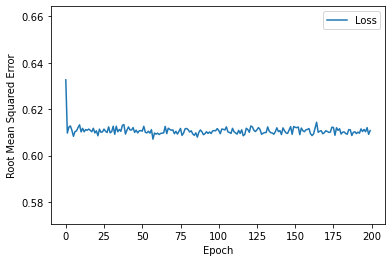

In [55]:
# Hyperparameters:
learning_rate = 0.05
epochs = 200
batch_size = 100

label_name="median_house_value" 

# Invoke the functions.
my_model = build_model(learning_rate,feature_layer)
epochs, rmse = train_model(my_model, train_df, 
                           epochs, batch_size, label_name)

plot_the_loss_curve(epochs, rmse)

In [52]:
print("\n: Evaluate the new model on the test set:")
test_features = {name:np.array(value) for name, value in test_df.items()}
test_label = np.array(test_features.pop(label_name))
my_model.evaluate(x=test_features, y=test_label, batch_size=batch_size)


: Evaluate the new model on the test set:
37/37 [==============================] - 0s 2ms/step - loss: 0.3628 - root_mean_squared_error: 0.6023


[0.36276379227638245, 0.6022987365722656]